# Trajectory Prediction of Moving Objects using a VAE-LSTM model Approach
_for the EIT conference in Honghzu, China, 2024_

    Lin, Shuyu, et al. "Anomaly detection for time series using vae-lstm hybrid model." ICASSP 2020-2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP). Ieee, 2020.


- Trainingsdaten generieren mit großen Kreisen (Rauschen?, Einspeisemuster?)
- Netzwerk bauen (LSTM+VAE)
- Überlegen, wie eine sinnvolle Auswertung vorgenommen werden kann

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from sciopy import norm_data, plot_mesh
from tqdm import tqdm

from support import get_info, get_permele_diff, get_permidx_diff, rphi_to_xy, show_mesh

# to save the plots, set this to true
save_imgs = True
# Continue with n_el=32
n_el = 16
r_obj = 0.4
dist_exc = 8
step_meas = 4

load_path = f"data/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [2]:
for ele in os.listdir("data/"):
    print(ele, len(os.listdir("data/" + ele + "/")))

.ipynb_checkpoints 0
n_el=16_r_obj=0.3_dist_exc=8_step_meas=4 1000
n_el=32_r_obj=0.3_dist_exc=8_step_meas=4 1000
n_el=32_r_obj=0.4_dist_exc=8_step_meas=1 500
n_el=16_r_obj=0.4_dist_exc=8_step_meas=4 1000
n_el=32_r_obj=0.4_dist_exc=8_step_meas=4 500
n_el=16_r_obj=0.4_dist_exc=8_step_meas=1 500


## Evaluate differences

Between the simulated data from time $t_0$ and $t_1$ should be a recognizable difference. Let's evaluate how big this is. This difference is needed to make it possible to generalize the features of the LSTM and the VAE.

In [3]:
tmp = np.load(load_path + "sample_000000.npz", allow_pickle=True)

In [4]:
get_info(tmp)

anomaly : PyEITAnomaly_Circle(center=array([0.5, 0. ]), perm=100, r=0.4)
n_el : 16
h0 : 0.05


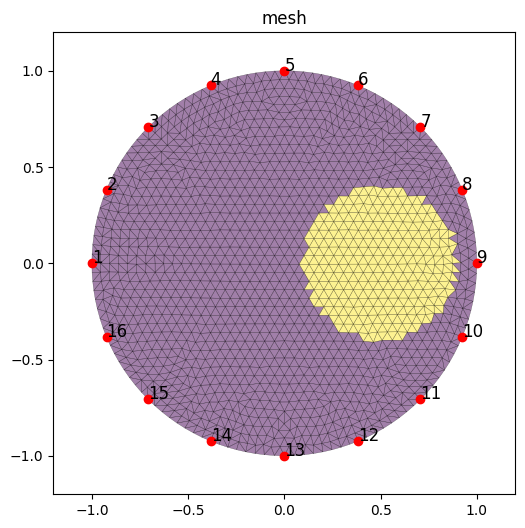

In [5]:
show_mesh(tmp, return_mesh=False)

In [6]:
tmp_1 = np.load(load_path + "sample_000000.npz", allow_pickle=True)
tmp_2 = np.load(load_path + "sample_000001.npz", allow_pickle=True)

In [7]:
get_info(tmp_1)
get_info(tmp_2)

anomaly : PyEITAnomaly_Circle(center=array([0.5, 0. ]), perm=100, r=0.4)
n_el : 16
h0 : 0.05
anomaly : PyEITAnomaly_Circle(center=array([0.49996036, 0.00629561]), perm=100, r=0.4)
n_el : 16
h0 : 0.05


In [8]:
if os.path.isfile("saves/" + load_path.split("/")[1] + "_diff_cnt.npy") == False:
    diff_cnt = list()
    diff_idx = list()

    for i in tqdm(range(len(os.listdir(load_path)) - 1)):
        tmp_1 = np.load(
            load_path + "sample_{:06d}.npz".format(i),
            allow_pickle=True,
        )
        tmp_2 = np.load(
            load_path + "sample_{:06d}.npz".format(i + 1),
            allow_pickle=True,
        )

        diff_cnt.append(get_permele_diff(tmp_1, tmp_2))
        diff_idx.append(get_permidx_diff(tmp_1, tmp_2))

    diff_cnt = np.array(diff_cnt)
    diff_idx = np.array(diff_idx)

    np.save("saves/" + load_path.split("/")[1] + "_diff_cnt.npy", diff_cnt)
    np.save("saves/" + load_path.split("/")[1] + "_diff_idx.npy", diff_idx)
else:
    diff_cnt = np.load(
        "saves/" + load_path.split("/")[1] + "_diff_cnt.npy", allow_pickle=True
    )
    diff_idx = np.load(
        "saves/" + load_path.split("/")[1] + "_diff_idx.npy", allow_pickle=True
    )

100%|███████████████████████████████████████████████████| 999/999 [40:16<00:00,  2.42s/it]


In [9]:
if os.path.isfile("saves/" + load_path.split("/")[1] + "_v_data.npy") == False:
    v_data = list()

    for i in tqdm(range(len(os.listdir(load_path)) - 1)):
        tmp_1 = np.load(load_path + "sample_{:06d}.npz".format(i), allow_pickle=True)
        v_data.append(norm_data(tmp_1["v_obj"]))
    v_data = np.array(v_data)

    ae_v = list()
    for i in range(v_data.shape[0] - 1):
        ae_v.append(np.sum(np.abs(v_data[i, :] - v_data[i + 1, :])))
    ae_v = np.array(ae_v)

    np.save("saves/" + load_path.split("/")[1] + "_v_data.npy", v_data)
    np.save("saves/" + load_path.split("/")[1] + "_ae_v.npy", ae_v)
else:
    v_data = np.load(
        "saves/" + load_path.split("/")[1] + "_v_data.npy", allow_pickle=True
    )
    ae_v = np.load("saves/" + load_path.split("/")[1] + "_ae_v.npy", allow_pickle=True)

100%|██████████████████████████████████████████████████| 999/999 [00:02<00:00, 397.18it/s]


## Difference in perm vector

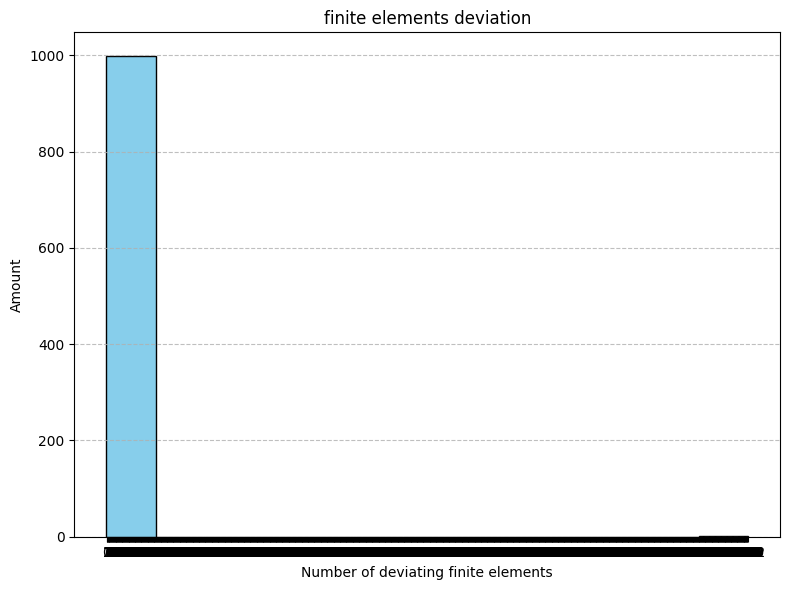

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(
    diff_cnt, bins=len(np.unique(diff_cnt)), color="skyblue", edgecolor="black", alpha=1
)
plt.xticks(ticks=np.arange(np.max(diff_cnt)) + 0.5, labels=np.arange(np.max(diff_cnt)))
plt.title("finite elements deviation")
plt.xlabel("Number of deviating finite elements")
plt.ylabel("Amount")
plt.grid(axis="y", linestyle="--", alpha=0.8)
plt.tight_layout()
if save_imgs:
    plt.savefig(f"images/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}_diff_cnt.pdf")
    plt.savefig(
        f"images/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}_diff_cnt.png", dpi=200
    )
plt.show()

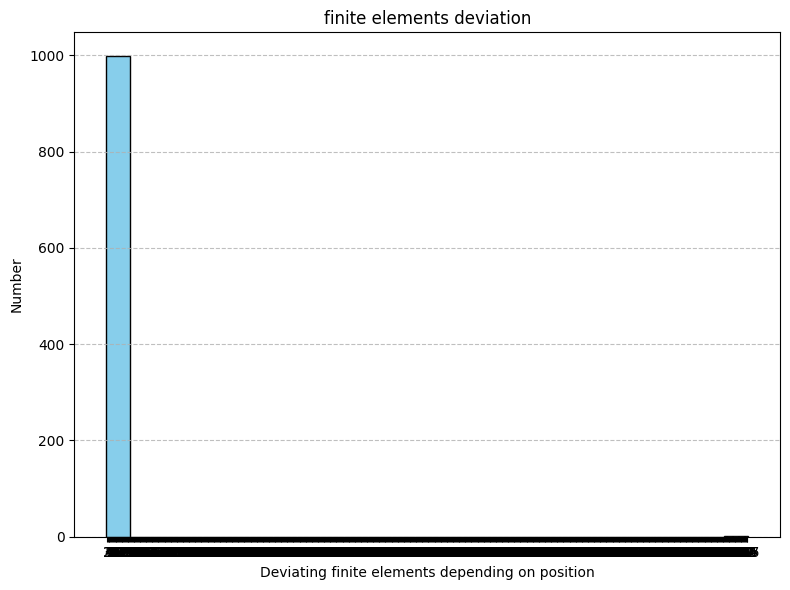

In [11]:
bins = np.arange(np.min(diff_idx), np.max(diff_idx))
plt.figure(figsize=(8, 6))
plt.hist(
    diff_idx,
    bins=len(np.unique(diff_idx)),  # np.max(diff_idx) - np.min(diff_idx),
    color="skyblue",
    edgecolor="black",
    alpha=1,
)
plt.xticks(
    ticks=np.arange(np.min(diff_idx), np.max(diff_idx)) + 0.5,
    labels=np.arange(np.min(diff_idx), np.max(diff_idx)),
)
plt.title("finite elements deviation")
plt.xlabel("Deviating finite elements depending on position")
plt.ylabel("Number")
plt.grid(axis="y", linestyle="--", alpha=0.8)
plt.tight_layout()
if save_imgs:
    plt.savefig(f"images/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}_diff_idx.pdf")
    plt.savefig(
        f"images/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}_diff_idx.png", dpi=200
    )
plt.show()

## Difference in $v$ vector

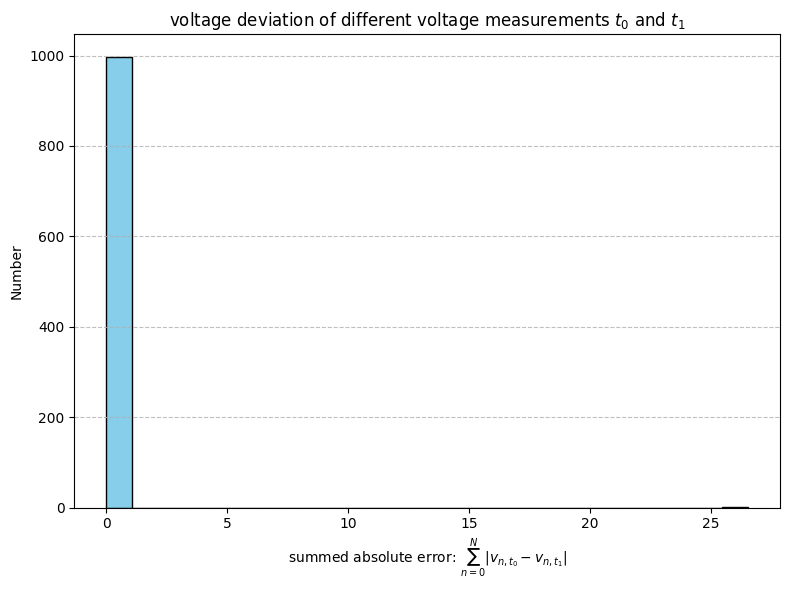

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(
    ae_v,
    bins=25,
    color="skyblue",
    edgecolor="black",
    alpha=1,
)
plt.title("voltage deviation of different voltage measurements $t_0$ and $t_1$")
plt.xlabel("summed absolute error: $\sum_{n=0}^N |v_{n,t_0} - v_{n,t_1}| $")
plt.ylabel("Number")
plt.grid(axis="y", linestyle="--", alpha=0.8)
plt.tight_layout()
if save_imgs:
    plt.savefig(f"images/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}_ae_v.pdf")
    plt.savefig(f"images/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}_ae_v.png", dpi=200)
plt.show()

## Visual

In [13]:
v_empty = tmp["v_empty"]

<StemContainer object of 3 artists>

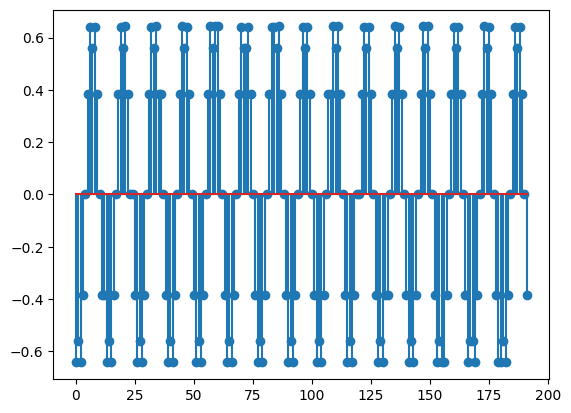

In [14]:
plt.stem(v_empty)

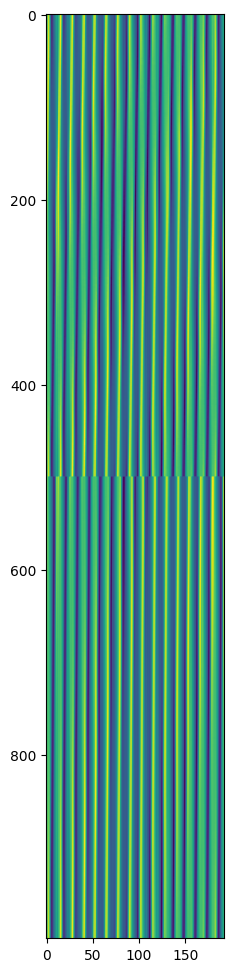

In [15]:
plt.figure(figsize=(20, 12))
plt.imshow((v_data[:, :] - v_empty) ** (1 / 1))